<a href="https://colab.research.google.com/github/dennistay1981/Resources/blob/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Data_science_approaches_to_mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descriptive analytics: cross-tabulating metaphor sources and targets

In [ ]:
#Import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#Import data
data = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Descriptive.csv')

# Cross-tabulation
crosstab = pd.crosstab(data['SOURCE'], data['TARGET'])
# Observed frequencies
observed = crosstab.values
# Expected frequencies
chi2, p, dof, expected = chi2_contingency(observed)
# Pearson's residuals
residuals = (observed - expected) / np.sqrt(expected)
# Cramer's V
n = observed.sum()
phi2 = chi2 / n
r, k = observed.shape
phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
rcorr = r - ((r - 1)**2) / (n - 1)
kcorr = k - ((k - 1)**2) / (n - 1)
cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Combine observed frequencies and residuals into a single DataFrame
combined_data = pd.DataFrame(observed, index=crosstab.index, columns=crosstab.columns)
combined_data = combined_data.astype(str) + ' (' + pd.DataFrame(residuals, index=crosstab.index, columns=crosstab.columns).round(2).astype(str) + ')'

# Mark statistically significant residuals using a threshold of +-1.96 (approximately 95% confidence)
significant_residuals = np.where(np.abs(residuals) > 1.96)

for i, j in zip(*significant_residuals):
    combined_data.iloc[i, j] = combined_data.iloc[i, j] + "*"


# Calculate row and column totals
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)

# Heatmap with combined data and row/column totals
plt.figure(figsize=(12, 8))
ax = sns.heatmap(pd.DataFrame(residuals, index=crosstab.index, columns=crosstab.columns),  #note that, as specified, the heatmap will be colored according to the size of the residuals, but the annotations in each cell are the frequencies + residuals in brackets
                 annot=combined_data, fmt='', cmap='Greys', center=0, cbar=True, annot_kws={"size": 16})


# Annotate row totals on the right side of the heatmap
for i, total in enumerate(row_totals):
  ax.text(len(crosstab.columns) + 0.1, i+0.5, total, ha='center', va='center', fontsize=16, color='gray')

# Annotate column totals at the bottom of the heatmap
for j, total in enumerate(col_totals):
  ax.text(j+0.5, len(crosstab.index) + 0.4,  total, ha='center', va='center', fontsize=16, color='gray')

plt.title('Observed Frequencies and Pearson Residuals (* = statistically significant)')
plt.xlabel('TARGET')
plt.ylabel('SOURCE')
plt.tight_layout()
plt.show()

# Print relevant statistics
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"Cramer's V: {cramer_v:.3f}")

Diagnostic (ARM)


In [ ]:
#Import Python libraries
!pip install mlxtend==0.23.1  #install an earlier version to prevent bug when running association_rules
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori


#Import data
data = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Diagnostic.csv')

#Split ASD and non-ASD individuals into two dataframes
data_ASD = data.loc[data['ASD']=='Y']
data_NASD = data.loc[data['ASD']=='N']

#convert transactions into lists: one for ASD, one for Non-ASD, and one for the overall dataset
transactions_ASD = data_ASD['sources'].apply(lambda t: t.split(','))
transactions_NASD = data_NASD['sources'].apply(lambda t: t.split(','))
transactions_all = data['sources'].apply(lambda t: t.split(','))

# Instantiate transaction encoder and identify unique items in transactions
encoder = TransactionEncoder().fit(transactions_ASD)
encoder2 = TransactionEncoder().fit(transactions_NASD)
encoder3 = TransactionEncoder().fit(transactions_all)

# One-hot encode transactions
onehot_ASD = encoder.transform(transactions_ASD)
onehot_NASD = encoder2.transform(transactions_NASD)
onehot_all = encoder3.transform(transactions_all)

# Convert one-hot encoded data to DataFrame
onehot_ASD = pd.DataFrame(onehot_ASD, columns = encoder.columns_)
onehot_NASD = pd.DataFrame(onehot_NASD, columns = encoder2.columns_)
onehot_all = pd.DataFrame(onehot_all, columns = encoder3.columns_)

# Compute frequent itemsets using the Apriori algorithm
# i.e. what are the items (max length 3) that (jointly) appear in at least 5% of transactions
frequent_itemsets_ASD = apriori(onehot_ASD, min_support = 0.05, max_len = 3, use_colnames = True)  #minimum support value, maximum itemset length to be retained
frequent_itemsets_NASD = apriori(onehot_NASD, min_support = 0.05, max_len = 3, use_colnames = True)
frequent_itemsets_all = apriori(onehot_all, min_support = 0.05, max_len = 3, use_colnames = True)

# Compute all association rules for frequent_itemsets, limiting only to rules with support > 0.05
# i.e. both antecedent and consequent items jointly appear in at least 5% of transactions
rules_ASD = association_rules(frequent_itemsets_ASD, metric = "support", min_threshold = 0.05)
rules_NASD = association_rules(frequent_itemsets_NASD, metric = "support", min_threshold = 0.05)
rules_all = association_rules(frequent_itemsets_all, metric = "support", min_threshold = 0.05)

# Replace frozen sets with strings
rules_ASD['antecedents'] = rules_ASD['antecedents'].apply(lambda a: ','.join(list(a)))
rules_ASD['consequents'] = rules_ASD['consequents'].apply(lambda a: ','.join(list(a)))
rules_NASD['antecedents'] = rules_NASD['antecedents'].apply(lambda a: ','.join(list(a)))
rules_NASD['consequents'] = rules_NASD['consequents'].apply(lambda a: ','.join(list(a)))
rules_all['antecedents'] = rules_all['antecedents'].apply(lambda a: ','.join(list(a)))
rules_all['consequents'] = rules_all['consequents'].apply(lambda a: ','.join(list(a)))

# Sort rules by confidence, then lift, then support in descending order
rules_ASD = rules_ASD.sort_values(['confidence', 'lift', 'support'], ascending=[False, False, False])
rules_NASD = rules_NASD.sort_values(['confidence', 'lift', 'support'], ascending=[False, False, False])
rules_all = rules_all.sort_values(['confidence', 'lift', 'support'], ascending=[False, False, False])



Predictive (survival regression)


In [ ]:
#Install lifelines
!pip install lifelines

In [17]:
#Import Python libraries
from lifelines import KaplanMeierFitter
import pandas as pd
import seaborn as sns

#Import data
data = pd.read_csv('https://raw.githubusercontent.com/dennistay1981/Resources/refs/heads/main/Code%20and%20data%20in%20publications/Chapter%3A%20Data%20science%20approaches%20to%20metaphor%20and%20mental%20health/Predictive.csv')

In [ ]:
"""
Plot survival function by INITIATOR
"""
ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'].Turns,
               event_observed=data.loc[data.Initiator =='T'].Attrition, label='Therapist').plot_survival_function(ax=ax, linestyle='-', color='black')

ax.hlines(0.5, 0, kmf_A.median_survival_time_ , linestyle=':')
ax.vlines(kmf_A.median_survival_time_ , 0, 0.5, linestyle=':')


kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Initiator =='C'].Turns,
               event_observed=data.loc[data.Initiator =='C'].Attrition, label='Client').plot_survival_function(ax=ax, linestyle='--', color='black')

ax.hlines(0.5, 0, kmf_B.median_survival_time_ , linestyle=':')
ax.vlines(kmf_B.median_survival_time_, 0, 0.5, linestyle=':')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 24))
plt.title('Survival curve by INITIATOR')

plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])



#to add risk counts table
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_A, kmf_B, ax=ax, fontsize=6)
plt.tight_layout()
plt.show()

In [ ]:
"""
Plot survival function by APPROACH
"""
ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Approach =='CBT'].Turns,
               event_observed=data.loc[data.Approach =='CBT'].Attrition, label='CBT').plot_survival_function(ax=ax, linestyle='-', color='black')
ax.hlines(0.5, 0, kmf_A.median_survival_time_ , linestyle=':')
ax.vlines(kmf_A.median_survival_time_ , 0, 0.5, linestyle=':')


kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Approach =='PA'].Turns,
               event_observed=data.loc[data.Approach =='PA'].Attrition, label='PA').plot_survival_function(ax=ax, linestyle='--', color='black')
ax.hlines(0.5, 0, kmf_B.median_survival_time_ , linestyle=':')
ax.vlines(kmf_B.median_survival_time_ , 0, 0.5, linestyle=':')


plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 24))
plt.title('Survival curve by APPROACH')

plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])

#to add risk counts table
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_A, kmf_B, ax=ax, fontsize=6)
plt.tight_layout()
plt.show()

In [ ]:
"""
Fitting Cox's Proportional Hazards model
"""
#Fit the selected data to CoxPHFitter and specify survival duration and event columns.
from lifelines import CoxPHFitter
# Initialize and fit the model
coxph = CoxPHFitter()
coxph.fit(data, duration_col='Turns', event_col='Attrition', formula="Initiator + Approach")
coxph.print_summary()



/tmp/ipython-input-287234894.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Turns,
/tmp/ipython-input-287234894.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  event_observed=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Attrition, label='CBT Therapist').plot_survival_function(ax=ax, linestyle='-', color='black')
/tmp/ipython-input-287234894.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = kmf_B.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'PA'].Turns,
/tmp/ipython-input-287234894.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  event_observed=data.loc[data.Initiator =='T'][data.Approach == 'PA'].Attrition, label='PA Therapist').plot_survival_function(ax=ax, linestyle='--', color='black')


(0.0, 1.05)

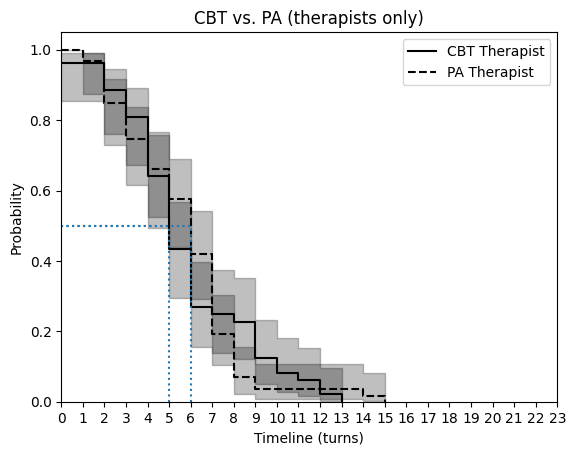

In [30]:
"""
Exploring interaction effects with survival functions
1. CBT vs. PA within therapists only
"""

ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Turns,
               event_observed=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Attrition, label='CBT Therapist').plot_survival_function(ax=ax, linestyle='-', color='black')
ax.hlines(0.5, 0, kmf_A.median_survival_time_ , linestyle=':')
ax.vlines(kmf_A.median_survival_time_ , 0, 0.5, linestyle=':')


kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'PA'].Turns,
               event_observed=data.loc[data.Initiator =='T'][data.Approach == 'PA'].Attrition, label='PA Therapist').plot_survival_function(ax=ax, linestyle='--', color='black')

ax.hlines(0.5, 0, kmf_B.median_survival_time_ , linestyle=':')
ax.vlines(kmf_B.median_survival_time_, 0, 0.5, linestyle=':')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 24))
plt.title('CBT vs. PA (therapists only)')

plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])

In [ ]:
"""
Exploring interaction effects with survival functions
2. CBT vs. PA within clients only
"""

ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Initiator =='C'][data.Approach == 'CBT'].Turns,
               event_observed=data.loc[data.Initiator =='C'][data.Approach == 'CBT'].Attrition, label='CBT Client').plot_survival_function(ax=ax, linestyle='-', color='black')
ax.hlines(0.5, 0, kmf_A.median_survival_time_ , linestyle=':')
ax.vlines(kmf_A.median_survival_time_ , 0, 0.5, linestyle=':')


kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Initiator =='C'][data.Approach == 'PA'].Turns,
               event_observed=data.loc[data.Initiator =='C'][data.Approach == 'PA'].Attrition, label='PA Client').plot_survival_function(ax=ax, linestyle='--', color='black')

ax.hlines(0.5, 0, kmf_B.median_survival_time_ , linestyle=':')
ax.vlines(kmf_B.median_survival_time_, 0, 0.5, linestyle=':')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 24))
plt.title('CBT vs. PA (clients only)')

plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])

/tmp/ipython-input-1686457616.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Turns,
/tmp/ipython-input-1686457616.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  event_observed=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Attrition, label='CBT Therapist').plot_survival_function(ax=ax, linestyle='-', color='black')
/tmp/ipython-input-1686457616.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = kmf_B.fit(durations=data.loc[data.Initiator =='C'][data.Approach == 'CBT'].Turns,
/tmp/ipython-input-1686457616.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  event_observed=data.loc[data.Initiator =='C'][data.Approach == 'CBT'].Attrition, label='CBT Client').plot_survival_function(ax=ax, linestyle='--', color='black')


(0.0, 1.0397517961782818)

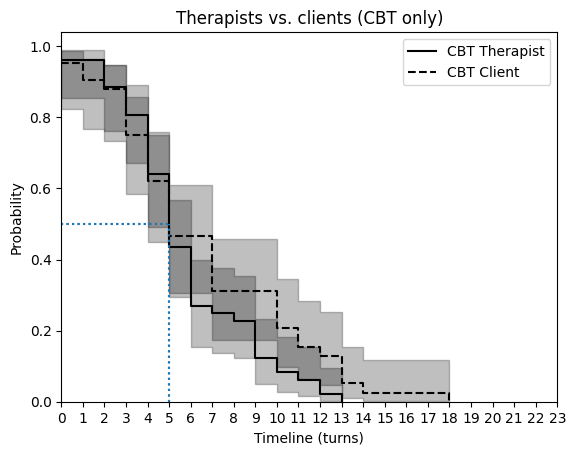

In [32]:
"""
Exploring interaction effects with survival functions
3. Therapists vs. clients within CBT only
"""

ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Turns,
               event_observed=data.loc[data.Initiator =='T'][data.Approach == 'CBT'].Attrition, label='CBT Therapist').plot_survival_function(ax=ax, linestyle='-', color='black')
ax.hlines(0.5, 0, kmf_A.median_survival_time_ , linestyle=':')
ax.vlines(kmf_A.median_survival_time_ , 0, 0.5, linestyle=':')


kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Initiator =='C'][data.Approach == 'CBT'].Turns,
               event_observed=data.loc[data.Initiator =='C'][data.Approach == 'CBT'].Attrition, label='CBT Client').plot_survival_function(ax=ax, linestyle='--', color='black')

ax.hlines(0.5, 0, kmf_B.median_survival_time_ , linestyle=':')
ax.vlines(kmf_B.median_survival_time_, 0, 0.5, linestyle=':')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 24))
plt.title('Therapists vs. clients (CBT only)')

plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])


In [ ]:
"""
Exploring interaction effects with survival functions
4. Therapists vs. clients within PA only
"""

ax = plt.subplot(111)

kmf_A = KaplanMeierFitter()
ax = kmf_A.fit(durations=data.loc[data.Initiator =='T'][data.Approach == 'PA'].Turns,
               event_observed=data.loc[data.Initiator =='T'][data.Approach == 'PA'].Attrition, label='PA Therapist').plot_survival_function(ax=ax, linestyle='-', color='black')
ax.hlines(0.5, 0, kmf_A.median_survival_time_ , linestyle=':')
ax.vlines(kmf_A.median_survival_time_ , 0, 0.5, linestyle='-:')


kmf_B = KaplanMeierFitter()
ax = kmf_B.fit(durations=data.loc[data.Initiator =='C'][data.Approach == 'PA'].Turns,
               event_observed=data.loc[data.Initiator =='C'][data.Approach == 'PA'].Attrition, label='PA Client').plot_survival_function(ax=ax, linestyle='--', color='black')

ax.hlines(0.5, 0, kmf_B.median_survival_time_ , linestyle=':')
ax.vlines(kmf_B.median_survival_time_, 0, 0.5, linestyle=':')

plt.legend()
plt.ylabel('Probability')
plt.xlabel('Timeline (turns)')
plt.xticks(range(0, 24))
plt.title('Therapists vs. clients (PA only)')

plt.xlim(0, plt.xlim()[1])
plt.ylim(0, plt.ylim()[1])